# from cloud

In [0]:
# from google.colab import auth
# auth.authenticate_user()

# project_id = 'peaceful-impact-247117'
# bucket_name = 'ml_collisions-data1'

# !gcloud config set project {project_id}
# !gsutil -m cp -r gs://ml-collisions-data1/hdf5_data/ /content/

# set vars

In [0]:
from __future__ import print_function, division
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import timeit
import h5py
from torch.utils.data import Dataset, DataLoader
from scipy import stats
from google.colab import files
from torch.nn import functional as F
from torch.autograd import Variable

In [0]:
batch_size = 32
lr = 1e-7
# !mkdir /content/checkpoints/1e-4
momentum = 0.99
num_epochs = 25
percentage_train = 0.8
percentage_val = 0.1
lr_decay = 0.1
step_size = 2
# loss_weights = [1,0.5,0.5,0.5]
loss_weights = [0,0.5,0.5,0.5,0.5]
nphi = 1
plot_rate = 250
output_rate = 500
val_rate = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# nets

In [0]:
def conv3x3(in_planes, out_planes):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=1, bias=True)

class UnetDownBlock(nn.Module):
   
    def __init__(self, inplanes, planes, predownsample_block):
        
        super(UnetDownBlock, self).__init__()
        
        self.predownsample_block = predownsample_block
        self.conv1 = conv3x3(inplanes, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        
    def forward(self, x):
        
        x = self.predownsample_block(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        
        return x
    
class UnetUpBlock(nn.Module):
   
    def __init__(self, inplanes, planes, postupsample_block=None):
        
        super(UnetUpBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        
        if postupsample_block is None: 
            
            self.postupsample_block = nn.ConvTranspose2d(in_channels=planes,
                                                         out_channels=planes//2,
                                                         kernel_size=2,
                                                         stride=2)
            
        else:
            
            self.postupsample_block = postupsample_block
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.postupsample_block(x)
        
        return x
    
    
class Unet(nn.Module):
    
    def __init__(self):
        
        super(Unet, self).__init__()
        
        self.predownsample_block = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.identity_block = nn.Sequential()
        
        self.block1 = UnetDownBlock(
                                    predownsample_block=self.identity_block,
                                    inplanes=2, planes=64
                                    )
        
        self.block2_down = UnetDownBlock(
                                         predownsample_block=self.predownsample_block,
                                         inplanes=64, planes=128
                                         )
        
        self.block3_down = UnetDownBlock(
                                         predownsample_block=self.predownsample_block,
                                         inplanes=128, planes=256
                                         )

        self.block4_down = UnetDownBlock(
                                         predownsample_block=self.predownsample_block,
                                         inplanes=256, planes=512
                                         )
        
        self.block5_down = UnetDownBlock(
                                         predownsample_block=self.predownsample_block,
                                         inplanes=512, planes=1024
                                         )
        
        self.block1_up = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                                  kernel_size=2, stride=2)
        
        self.block2_up = UnetUpBlock(
                                     inplanes=1024, planes=512
                                     )
        
        self.block3_up = UnetUpBlock(
                                     inplanes=512, planes=256
                                     )
        
        self.block4_up = UnetUpBlock(
                                     inplanes=256, planes=128
                                     )
        
        self.block5 = UnetUpBlock(
                                  inplanes=128, planes=64,
                                  postupsample_block=self.identity_block
                                  )
        
        self.logit_conv = nn.Conv2d(
                                    in_channels=64, out_channels=2, kernel_size=1,
                                    )
        
        
    def forward(self, x):
        
        features_1s_down = self.block1(x)
        features_2s_down = self.block2_down(features_1s_down)
        features_4s_down = self.block3_down(features_2s_down)
        features_8s_down = self.block4_down(features_4s_down)
        
        features_16s = self.block5_down(features_8s_down)
        
        features_8s_up = self.block1_up(features_16s)
        features_8s_up = torch.cat([features_8s_down, features_8s_up],dim=1)
        
        features_4s_up = self.block2_up(features_8s_up)
        features_4s_up = torch.cat([features_4s_down, features_4s_up],dim=1)
        
        features_2s_up = self.block3_up(features_4s_up)
        features_2s_up = torch.cat([features_2s_down, features_2s_up],dim=1)
        
        features_1s_up = self.block4_up(features_2s_up)
        features_1s_up = torch.cat([features_1s_down, features_1s_up],dim=1)
        
        features_final = self.block5(features_1s_up)
        
        logits = self.logit_conv(features_final)
       
        return logits

In [0]:
class VGG(nn.Module):
    
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 2
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    return model

def vgg16(pretrained=False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

  
class VGG16(nn.Module):
    
    def __init__(self, n_layers, usegpu=True):
        super(VGG16,self).__init__()
        
        self.cnn = vgg16(pretrained=False)
        self.cnn = nn.Sequential(*list(self.cnn.children())[0])
        self.cnn = nn.Sequential(*list(self.cnn.children())[:n_layers])
        
    def __get_outputs(self,x):
        
        outputs = []
        for i, layer in enumerate(self.cnn.children()):
            x = layer(x)
            outputs.append(x)
            
        return outputs
    
    def forward(self,x):
        outputs = self.__get_outputs(x)
        
        return outputs[-1]
   
    
class SkipVGG16(nn.Module):
    
    def __init__(self, usegpu=True):
        super(SkipVGG16, self).__init__()
        
        self.outputs = [3,8]
        self.n_filters = [64,128]
        
        self.model = VGG16(n_layers=16, usegpu=usegpu)
        
    def forward(self,x):
        
        out = []
        for i, layer in enumerate(list(self.model.children())[0]):
            x = layer(x)
            if i in self.outputs:
                out.append(x)
        out.append(x)
        
        return out
    
    
class ReNet(nn.Module):
    
    def __init__(self, n_input, n_units, patch_size=(1, 1), usegpu=True):
        super(ReNet, self).__init__()
        
        self.usegpu=usegpu
        
        self.patch_size_height = int(patch_size[0])
        self.patch_size_width = int(patch_size[1])
        
        assert self.patch_size_height >= 1
        assert self.patch_size_width >= 1
        
        self.tiling = False if ((self.patch_size_height == 1) and (
            self.patch_size_width == 1)) else True
                
        rnn_hor_n_inputs = n_input * self.patch_size_height * \
            self.patch_size_width
            
        self.rnn_hor = nn.GRU(rnn_hor_n_inputs, n_units,
                              num_layers=1, batch_first=True,
                              bidirectional=True)
        
        self.rnn_ver = nn.GRU(n_units * 2, n_units,
                              num_layers=1, batch_first=True,
                              bidirectional=True)
        
    def __tile(self,x):

        if (x.size(2) % self.patch_size_height) == 0:
            n_height_padding = 0
        else:
            n_height_padding = self.patch_size_height - \
                x.size(2) % self.patch_size_height
        if (x.size(3) % self.patch_size_width) == 0:
            n_width_padding = 0
        else:
            n_width_padding = self.patch_size_width - \
                x.size(3) % self.patch_size_width

        n_top_padding = n_height_padding / 2
        n_bottom_padding = n_height_padding - n_top_padding

        n_left_padding = n_width_padding / 2
        n_right_padding = n_width_padding - n_left_padding

        x = F.pad(x, (n_left_padding, n_right_padding,
                      n_top_padding, n_bottom_padding))

        b, n_filters, n_height, n_width = x.size()

        assert n_height % self.patch_size_height == 0
        assert n_width % self.patch_size_width == 0

        new_height = n_height / self.patch_size_height
        new_width = n_width / self.patch_size_width

        x = x.view(b, n_filters, new_height, self.patch_size_height,
                   new_width, self.patch_size_width)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.contiguous()
        x = x.view(b, new_height, new_width, self.patch_size_height *
                   self.patch_size_width * n_filters)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()

        return x
                
    def __swap_hw(self, x):

        # x : b, nf, h, w
        x = x.permute(0, 1, 3, 2)
        x = x.contiguous()
        #  x : b, nf, w, h

        return x
    
    def rnn_forward(self, x, hor_or_ver):

        # x : b, nf, h, w
        assert hor_or_ver in ['hor', 'ver']

        if hor_or_ver == 'ver':
            x = self.__swap_hw(x)

        x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
        b, n_height, n_width, n_filters = x.size()
        # x : b, h, w, nf

        x = x.view(b * n_height, n_width, n_filters)
        # x : b * h, w, nf
        if hor_or_ver == 'hor':
            x, _ = self.rnn_hor(x)
        elif hor_or_ver == 'ver':
            x, _ = self.rnn_ver(x)
            
        x = x.contiguous()
        x = x.view(b, n_height, n_width, -1)
        # x : b, h, w, nf

        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()
        # x : b, nf, h, w

        if hor_or_ver == 'ver':
            x = self.__swap_hw(x)

        return x
    
    def forward(self, x):

        # x : b, nf, h, w
        if self.tiling:
            x = self.__tile(x)

        x = self.rnn_forward(x, 'hor')
        x = self.rnn_forward(x, 'ver')

        return x
        

class ReSeg(nn.Module):
    
    def __init__(self, usegpu=True):
        super(ReSeg, self).__init__()
        
        self.cnn = SkipVGG16(usegpu=usegpu)
        
        self.renet1 = ReNet(256, 100, usegpu=usegpu)
        self.renet2 = ReNet(200, 100, usegpu=usegpu)
        
        self.upsampling1 = nn.ConvTranspose2d(200, 100,
                                              kernel_size=2,stride=2)
        self.relu1 = nn.ReLU()
        self.upsampling2 = nn.ConvTranspose2d(100 + self.cnn.n_filters[1], 100,
                                              kernel_size=2,stride=2)
        self.relu2 = nn.ReLU()
        
        self.final = nn.Conv2d(
                                in_channels = 100 + self.cnn.n_filters[0], 
                                out_channels = 1,
                                kernel_size=1,stride=1)
        
    def forward(self, x):
        
        first_skip, second_skip, x_enc = self.cnn(x)
        x_enc = self.renet1(x_enc)
        x_enc = self.renet2(x_enc)
        x_dec = self.relu1(self.upsampling1(x_enc))
        x_dec = torch.cat((x_dec, second_skip), dim=1)
        x_dec = self.relu2(self.upsampling2(x_dec))
        x_dec = torch.cat((x_dec, first_skip), dim=1)
        x_out = self.final(x_dec)
        
        return x_out

In [0]:
class VGG(nn.Module):
    
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 2
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    return model

def vgg16(pretrained=False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

  
class VGG16(nn.Module):
    
    def __init__(self, n_layers, usegpu=True):
        super(VGG16,self).__init__()
        
        self.cnn = vgg16(pretrained=False)
        self.cnn = nn.Sequential(*list(self.cnn.children())[0])
        self.cnn = nn.Sequential(*list(self.cnn.children())[:n_layers])
        
    def __get_outputs(self,x):
        
        outputs = []
        for i, layer in enumerate(self.cnn.children()):
            x = layer(x)
            outputs.append(x)
            
        return outputs
    
    def forward(self,x):
        outputs = self.__get_outputs(x)
        
        return outputs[-1]
  
    
class ReNet(nn.Module):
    
    def __init__(self, n_input, n_units, patch_size=(1, 1), usegpu=True):
        super(ReNet, self).__init__()
        
        self.usegpu=usegpu
        
        self.patch_size_height = int(patch_size[0])
        self.patch_size_width = int(patch_size[1])
        
        assert self.patch_size_height >= 1
        assert self.patch_size_width >= 1
        
        self.tiling = False if ((self.patch_size_height == 1) and (
            self.patch_size_width == 1)) else True
                
        rnn_hor_n_inputs = n_input * self.patch_size_height * \
            self.patch_size_width
            
        self.rnn_hor = nn.GRU(rnn_hor_n_inputs, n_units,
                              num_layers=1, batch_first=True,
                              bidirectional=True)
        
        self.rnn_ver = nn.GRU(n_units * 2, n_units,
                              num_layers=1, batch_first=True,
                              bidirectional=True)
        
    def __tile(self,x):

        if (x.size(2) % self.patch_size_height) == 0:
            n_height_padding = 0
        else:
            n_height_padding = self.patch_size_height - \
                x.size(2) % self.patch_size_height
        if (x.size(3) % self.patch_size_width) == 0:
            n_width_padding = 0
        else:
            n_width_padding = self.patch_size_width - \
                x.size(3) % self.patch_size_width

        n_top_padding = n_height_padding / 2
        n_bottom_padding = n_height_padding - n_top_padding

        n_left_padding = n_width_padding / 2
        n_right_padding = n_width_padding - n_left_padding

        x = F.pad(x, (n_left_padding, n_right_padding,
                      n_top_padding, n_bottom_padding))

        b, n_filters, n_height, n_width = x.size()

        assert n_height % self.patch_size_height == 0
        assert n_width % self.patch_size_width == 0

        new_height = n_height / self.patch_size_height
        new_width = n_width / self.patch_size_width

        x = x.view(b, n_filters, new_height, self.patch_size_height,
                   new_width, self.patch_size_width)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.contiguous()
        x = x.view(b, new_height, new_width, self.patch_size_height *
                   self.patch_size_width * n_filters)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()

        return x
                
    def __swap_hw(self, x):

        # x : b, nf, h, w
        x = x.permute(0, 1, 3, 2)
        x = x.contiguous()
        #  x : b, nf, w, h

        return x
    
    def rnn_forward(self, x, hor_or_ver):

        # x : b, nf, h, w
        assert hor_or_ver in ['hor', 'ver']

        if hor_or_ver == 'ver':
            x = self.__swap_hw(x)

        x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
        b, n_height, n_width, n_filters = x.size()
        # x : b, h, w, nf

        x = x.view(b * n_height, n_width, n_filters)
        # x : b * h, w, nf
        if hor_or_ver == 'hor':
            x, _ = self.rnn_hor(x)
        elif hor_or_ver == 'ver':
            x, _ = self.rnn_ver(x)
            
        x = x.contiguous()
        x = x.view(b, n_height, n_width, -1)
        # x : b, h, w, nf

        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()
        # x : b, nf, h, w

        if hor_or_ver == 'ver':
            x = self.__swap_hw(x)

        return x
    
    def forward(self, x):

        # x : b, nf, h, w
        if self.tiling:
            x = self.__tile(x)

        x = self.rnn_forward(x, 'hor')
        x = self.rnn_forward(x, 'ver')

        return x


class ConvGRUCell(nn.Module):
    
    def __init__(self, input_size, hidden_size, kernel_size, usegpu=True):
        super(ConvGRUCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.usegpu = usegpu
        
        _n_inputs = self.input_size + self.hidden_size
        self.conv_gates = nn.Conv2d(_n_inputs,
                                    2 * self.hidden_size,
                                    self.kernel_size,
                                    padding=self.kernel_size // 2)

        self.conv_ct = nn.Conv2d(_n_inputs, self.hidden_size,
                                 self.kernel_size,
                                 padding=self.kernel_size // 2)
        
    def forward(self, x, hidden):
        
        batch_size, _, height, width = x.size()
        
        if hidden is None:
            size_h = [batch_size, self.hidden_size, height, width]
            hidden = Variable(torch.zeros(size_h))

            if self.usegpu:
                hidden = hidden.cuda()
                
        c1 = self.conv_gates(torch.cat((x, hidden), dim=1))
        rt, ut = c1.chunk(2, 1)

        reset_gate = torch.sigmoid(rt)
        update_gate = torch.sigmoid(ut)

        gated_hidden = torch.mul(reset_gate, hidden)

        ct = torch.tanh(self.conv_ct(torch.cat((x, gated_hidden), dim=1)))

        next_h = torch.mul(update_gate, hidden) + (1 - update_gate) * ct

        return next_h
    

class RecurrentHourglass(nn.Module):
    
    def __init__(self, input_n_filters, hidden_n_filters, kernel_size,
                 n_levels, embedding_size, usegpu=True):
        super(RecurrentHourglass, self).__init__()
            
        assert n_levels >= 1
    
        self.input_n_filters = input_n_filters
        self.hidden_n_filters = hidden_n_filters
        self.kernel_size = kernel_size
        self.n_levels = n_levels
        self.embedding_size = embedding_size
        self.usegpu = usegpu
        
        self.convgru_cell = ConvGRUCell(self.hidden_n_filters,
                                        self.hidden_n_filters,
                                        self.kernel_size,
                                        self.usegpu)
        
        self.__generate_pre_post_convs()
        
    def __generate_pre_post_convs(self):
        
        def __get_conv(input_n_filters, output_n_filters):
            return nn.Conv2d(input_n_filters, output_n_filters,
                             self.kernel_size,
                             padding=self.kernel_size // 2)
            
        self.pre_conv_layers = [__get_conv(self.input_n_filters,
                                           self.hidden_n_filters), ]
    
        for _ in range(self.n_levels - 1):
            self.pre_conv_layers.append(__get_conv(self.hidden_n_filters,
                                                   self.hidden_n_filters))
        self.pre_conv_layers = nn.ModuleList(self.pre_conv_layers)
    
        self.post_conv_layers = [__get_conv(self.hidden_n_filters,
                                            self.embedding_size), ]
        for _ in range(self.n_levels - 1):
            self.post_conv_layers.append(__get_conv(self.hidden_n_filters,
                                                    self.hidden_n_filters))
        self.post_conv_layers = nn.ModuleList(self.post_conv_layers)
    
    def forward_encoding(self, x):
        
        convgru_outputs = []
        hidden = None
        for i in range(self.n_levels):
            x = F.relu(self.pre_conv_layers[i](x))
            hidden = self.convgru_cell(x, hidden)
            convgru_outputs.append(hidden)
            
        return convgru_outputs
    
    def forward_decoding(self, convgru_outputs):
        
        _last_conv_layer = self.post_conv_layers[self.n_levels - 1]
        _last_output = convgru_outputs[self.n_levels - 1]
        
        post_feature_map = F.relu(_last_conv_layer(_last_output))
        for i in range(self.n_levels - 1)[::-1]:
            post_feature_map += convgru_outputs[i]
            post_feature_map = self.post_conv_layers[i](post_feature_map)
            post_feature_map = F.relu(post_feature_map)
            
        return post_feature_map
    
    def forward(self, x):
        
        x = self.forward_encoding(x)
        x = self.forward_decoding(x)
        
        return x
    

class StackedRecurrentHourglass(nn.Module):
    
    def __init__(self, usegpu=True):
        super(StackedRecurrentHourglass, self).__init__()
        
        self.usegpu = usegpu
        
        self.base_cnn = self.__generate_base_cnn()
        
        self.enc_stacked_hourglass = self.__generate_enc_stacked_hg(64,3)
        
        self.stacked_renet = self.__generate_stacked_renet(64,2)
        
        self.decoder = self.__generate_decoder(64)
        
    def __generate_base_cnn(self):
        
        base_cnn = VGG16(n_layers=4, usegpu=self.usegpu)
        
        return base_cnn
    
    def __generate_enc_stacked_hg(self, input_n_filters, n_levels):
        
        stacked_hourglass = nn.Sequential()
        stacked_hourglass.add_module('Hourglass_1',
                                     RecurrentHourglass(
                                         input_n_filters=input_n_filters,
                                         hidden_n_filters=64,
                                         kernel_size=3,
                                         n_levels=n_levels,
                                         embedding_size=64,
                                         usegpu=self.usegpu))
        stacked_hourglass.add_module('pool_1',
                                     nn.MaxPool2d(2, stride=2))
        stacked_hourglass.add_module('Hourglass_2',
                                     RecurrentHourglass(
                                         input_n_filters=64,
                                         hidden_n_filters=64,
                                         kernel_size=3,
                                         n_levels=n_levels,
                                         embedding_size=64,
                                         usegpu=self.usegpu))        
        stacked_hourglass.add_module('pool_2',
                                     nn.MaxPool2d(2, stride=2))    

        return stacked_hourglass

    def __generate_stacked_renet(self, input_n_filters, n_renets):

        assert n_renets >= 1
        
        renet = nn.Sequential()
        renet.add_module('ReNet_1', ReNet(input_n_filters, 32,
                                          patch_size=(1, 1),
                                          usegpu=self.usegpu))
        for i in range(1, n_renets):
            renet.add_module('ReNet_{}'.format(i + 1),
                             ReNet(32 * 2, 32, patch_size=(1, 1),
                                   usegpu=self.usegpu))
            
        return renet
    
    def __generate_decoder(self, input_n_filters):
        
        decoder = nn.Sequential()
        decoder.add_module('ConvTranspose_1',
                           nn.ConvTranspose2d(input_n_filters,
                                              64,
                                              kernel_size=(2, 2),
                                              stride=(2, 2)))
        decoder.add_module('ReLU_1', nn.ReLU())
        decoder.add_module('ConvTranspose_2',
                           nn.ConvTranspose2d(64,
                                              64,
                                              kernel_size=(2, 2),
                                              stride=(2, 2)))
        decoder.add_module('ReLU_2', nn.ReLU())
        decoder.add_module('Final',
                           nn.ConvTranspose2d(64,
                                              1,
                                              kernel_size=(1, 1),
                                              stride=(1, 1)))
        
        return decoder
            
    def forward(self, x):
        
        x = self.base_cnn(x)
        x = self.enc_stacked_hourglass(x)
        x = self.stacked_renet(x)
        x = self.decoder(x)
        
        return x

# choose

In [0]:
#net = Unet().to(device)
net = ReSeg().to(device)
#net = StackedRecurrentHourglass().to(device)

# load data

In [0]:
def load_data_hdf(iphi):
  
  hf_f = h5py.File('/content/hdf5_data/hdf_f.h5','r')
  hf_df = h5py.File('/content/hdf5_data/hdf_df.h5','r')
  
  e_f = hf_f['e_f'][iphi]  
  i_f = hf_f['i_f'][iphi]
  e_df = hf_df['e_df'][iphi] 
  i_df = hf_df['i_df'][iphi]
  
  ind1,ind2,ind3 = i_f.shape
  
  f = np.zeros([ind2,2,ind1,ind1])
  df = np.zeros([ind2,2,ind1,ind1])

  for n in range(ind2):
    f[n,0,:,:-1] = e_f[:,n,:]
    f[n,1,:,:-1] = i_f[:,n,:]
    df[n,0,:,:-1] = e_df[:,n,:]
    df[n,1,:,:-1] = i_df[:,n,:]

    f[n,0,:,-1] = e_f[:,n,-1]
    f[n,1,:,-1] = i_f[:,n,-1]
    df[n,0,:,-1] = e_df[:,n,-1]
    df[n,1,:,-1] = i_df[:,n,-1]
    
  del i_f,e_f,i_df,e_df
  df+=f

  # instantiate variables for conservation properties and for normalization
  hf_cons = h5py.File('/content/hdf5_data/hdf_cons_fullvol.h5','r')
  hf_vol = h5py.File('/content/hdf5_data/hdf_vol.h5')
  cons = conservation_variables(hf_cons,hf_vol)
  
  hf_stats = h5py.File('/content/hdf5_data/hdf_stats.h5','r')
  zvars = stats_variables(hf_stats)
  
  for n in range(ind2):
    f[n] = (f[n]-zvars.mean_f)/zvars.std_f
#     df[n] = (df[n]-zvars.mean_df)/zvars.std_df
    df[n] = (df[n]-zvars.mean_fdf)/zvars.std_fdf
    
  zvars.mean_f = zvars.mean_f[np.newaxis]
  zvars.mean_df = zvars.mean_df[np.newaxis]
  zvars.mean_fdf = zvars.mean_fdf[np.newaxis]
  zvars.std_f = zvars.std_f[np.newaxis]
  zvars.std_df = zvars.std_df[np.newaxis]
  zvars.std_fdf = zvars.std_fdf[np.newaxis]
  
  for i in range(int(np.ceil(np.log(batch_size)/np.log(2)))):
    zvars.mean_f = np.concatenate((zvars.mean_f,zvars.mean_f),axis=0)
    zvars.mean_df = np.concatenate((zvars.mean_df,zvars.mean_df),axis=0)
    zvars.mean_fdf = np.concatenate((zvars.mean_fdf,zvars.mean_fdf),axis=0)
    zvars.std_f = np.concatenate((zvars.std_f,zvars.std_f),axis=0)
    zvars.std_df = np.concatenate((zvars.std_df,zvars.std_df),axis=0)  
    zvars.std_fdf = np.concatenate((zvars.std_fdf,zvars.std_fdf),axis=0)
  
  zvars.mean_f = torch.from_numpy(zvars.mean_f).to(device).float()
  zvars.mean_df = torch.from_numpy(zvars.mean_df).to(device).float()
  zvars.mean_fdf = torch.from_numpy(zvars.mean_fdf).to(device).float()
  zvars.std_f = torch.from_numpy(zvars.std_f).to(device).float()
  zvars.std_df = torch.from_numpy(zvars.std_df).to(device).float()
  zvars.std_fdf = torch.from_numpy(zvars.std_fdf).to(device).float()
       
  return f,df,ind2,zvars,cons

In [0]:
class stats_variables():
  
  def __init__(self, hf_stats):
    self.std_f = hf_stats['std_f'][...]
    self.std_df = hf_stats['std_df'][...]
    self.std_fdf = hf_stats['std_fdf'][...]
    self.mean_f = hf_stats['mean_f'][...]
    self.mean_df = hf_stats['mean_df'][...]
    self.mean_fdf = hf_stats['mean_fdf'][...]

In [0]:
class conservation_variables():

  def __init__(self, hf_cons, hf_vol):
    self.f0_dsmu = hf_cons['f0_dsmu'][...]
    self.f0_dvp = hf_cons['f0_dvp'][...]
    self.f0_nvp = hf_cons['f0_nvp'][...]
    self.f0_nmu = hf_cons['f0_nmu'][...]
    self.ptl_mass = hf_cons['ptl_mass'][...]
    self.sml_ev2j = 1.6022e-19
    
    self.temp = hf_cons['f0_T_ev'][...]
    self.vol = np.zeros([self.temp.shape[0],self.f0_nmu+1,self.temp.shape[1]])
    self.vol[0] = hf_vol['vole'][0]
    self.vol[1] = hf_vol['voli'][0]

In [0]:
class DistFuncDataset(Dataset):

    def __init__(self, f_array, df_array, temp_array, vol_array):
        self.data = torch.from_numpy(f_array).float()
        self.target = torch.from_numpy(df_array).float()
        self.temp = torch.from_numpy(temp_array).float()
        self.vol = torch.from_numpy(vol_array).float()
        
    def __len__(self):
        return len(self.data)
      
    def __getitem__(self, index):
        a = self.data[index]
        b = self.target[index]
        b = b.view(-1,32,32)
        c = self.temp[index]
        d = self.vol[index]
            
        return a, b, c, d

# split data

In [0]:
def split_data(f,df,cons,num_nodes):
    
    inds = np.arange(num_nodes)
    #np.random.seed(0)
    np.random.shuffle(inds) 
    
    num_train = int(np.floor(percentage_train*num_nodes))
    num_val = int(np.floor(percentage_val*num_nodes))
    
    train_inds = inds[:num_train]
    val_inds = inds[num_train:num_train+num_val]
    test_inds = inds[num_train+num_val:]
 
    f_train = f[train_inds]
    f_val = f[val_inds]
    f_test = f[test_inds]
        
    del f  
      
    df_train = df[train_inds]
    df_val = df[val_inds]
    df_test = df[test_inds]
    
    del df
        
    # temperature and volume separate arrays here
    temp = np.einsum('ij -> ji', cons.temp)   
    temp_train = temp[train_inds]
    temp_val = temp[val_inds]
    temp_test = temp[test_inds]
    
    del temp
    
    vol = np.einsum('ijk -> kji', cons.vol)
    vol_train = vol[train_inds]
    vol_val = vol[val_inds]
    vol_test = vol[test_inds]
    
    
    trainset = DistFuncDataset(f_train, df_train, temp_train, vol_train)
    
    trainloader = DataLoader(trainset, batch_size=batch_size, 
                             shuffle=True, pin_memory=True, num_workers=4)
    
    del f_train, df_train, temp_train, vol_train
    
    valset = DistFuncDataset(f_val, df_val, temp_val, vol_val)
    
    valloader = DataLoader(valset, batch_size=batch_size, 
                           shuffle=True, pin_memory=True, num_workers=4)
        
    return trainloader, valloader, f_test, df_test, temp_test, vol_test

# check props

In [0]:
# same procedure as col_f_convergence_eval
def check_properties_each(f_slice, cons, temp, vol, sp):
    
    f_slice = f_slice.float()
       
    if len(f_slice.shape) == 2:
      nperp, npar = f_slice.shape
      nbatch = 1
    elif len(f_slice.shape) == 3:  
      nbatch,nperp,npar = f_slice.shape
      
    vth = torch.sqrt(temp*cons.sml_ev2j/cons.ptl_mass[sp]) 
    
    vpar = np.linspace(-cons.f0_nvp,cons.f0_nvp,2*cons.f0_nvp+1)*cons.f0_dvp
    vperp = np.linspace(0,cons.f0_nmu,cons.f0_nmu+1)*cons.f0_dsmu
    
    
#     print('vth',vth*torch.from_numpy(cons.f0_dsmu))
#     print('vpar',torch.from_numpy(vpar)*vth[0])
#     print('vperp',torch.from_numpy(vperp)*vth[0])
    
    vpar = torch.tensor(vpar).float().to(device)
    vperp = torch.tensor(vperp).float().to(device)
        
    mass = cons.ptl_mass[sp]
    conv_factor_notemp = 1/np.sqrt((2*np.pi*cons.sml_ev2j/mass)**3)
    temp_factor = 1/torch.sqrt(temp)
    
    smu_n = cons.f0_dsmu/3 # smu_n = f0_dsmu/f0_mu0_factor, f0_mu0_factor = 3
    f_slice_norm = torch.einsum('ijk,i -> ijk',f_slice,temp_factor)*conv_factor_notemp/smu_n
      
    ones_tensor = torch.ones(nbatch,nperp,npar).float().to(device)
      
    vol_tensor = torch.einsum('ijk,ij -> ijk',ones_tensor,vol)
    vperp_tensor = torch.einsum('ijk,i,j -> ijk',ones_tensor,vth,vperp)
    vpar_tensor = torch.einsum('ijk,i,k -> ijk',ones_tensor,vth,vpar)
    
    mass_tensor = vol_tensor
    mom_tensor = vpar_tensor*cons.ptl_mass[sp]*vol_tensor
    energy_tensor = (vpar_tensor**2 + vperp_tensor**2)*cons.ptl_mass[sp]*vol_tensor
        
    mass_tensor, mom_tensor, energy_tensor = \
    mass_tensor.to(device), mom_tensor.to(device), energy_tensor.to(device)                   
         
    mass = torch.sum(f_slice_norm*mass_tensor, dim = (1,2))
    momentum = torch.sum(f_slice_norm*mom_tensor, dim = (1,2))
    energy = torch.sum(f_slice_norm*energy_tensor, dim = (1,2))
                
    return mass, momentum, energy

In [0]:
# makes calls to individual df/f property calculation
# computes more useful quantities as in col_f_core_m after the calls to col_f_convergence_eval 
def check_properties_main(f,df,temp,vol,cons):
  
  masse = torch.from_numpy(np.array([cons.ptl_mass[0]])).to(device).float()
  massi = torch.from_numpy(np.array([cons.ptl_mass[1]])).to(device).float()
  
  #print('df')
  dne,dpe,dwe = check_properties_each(df[:,0],cons,temp[:,0],vol[:,:,0],0)
  dni,dpi,dwi = check_properties_each(df[:,1],cons,temp[:,1],vol[:,:,1],1)
  
  #print('f')  
  ne,mome,ene = check_properties_each(f[:,0],cons,temp[:,0],vol[:,:,0],0)
  ni,momi,eni = check_properties_each(f[:,1],cons,temp[:,1],vol[:,:,1],1) 
      
  dne_n = torch.abs(dne/ne)
  dni_n = torch.abs(dni/ni)
  
  dp_p = torch.abs(dpi + dpe)/torch.max(torch.abs(momi + mome),1e-3*torch.max(massi,masse)*ne)
  
  dw_w = torch.abs((dwi + dwe)/(eni + ene))
  
  return dne_n,dni_n,dp_p,dw_w

In [0]:
# dataiter = iter(trainloader)
# data, targets, temp, vol = dataiter.next()
# data, targets, temp, vol = data.to(device), targets.to(device), temp.to(device), vol.to(device)     

# outputs = net(data)
# outputs = outputs.to(device)

# nbatch = len(data)     

# data_unnorm = data*zvars.std_f[:nbatch] + zvars.mean_f[:nbatch]
# targets_unnorm = targets*zvars.std_fdf[:nbatch] + zvars.mean_fdf[:nbatch]
# outputs_unnorm = outputs[:nbatch,0]*zvars.std_fdf[:nbatch,1] + zvars.mean_fdf[:nbatch,1]

# targets_nof = targets_unnorm - data_unnorm
# outputs_nof = outputs_unnorm[:nbatch] - data_unnorm[:nbatch,1]

# outputs_nof_to_cat = outputs_nof[:nbatch].unsqueeze(1)
# targets_nof_to_cat = targets_nof[:nbatch,0].unsqueeze(1)

# outputs_nof = torch.cat((outputs_nof_to_cat,targets_nof_to_cat),1)
# check_properties_main(data_unnorm[:,:,:,:-1],outputs_nof[:,:,:,:-1],temp,vol,cons)

# train

In [0]:
def train(trainloader,valloader,sp_flag,epoch,end,zvars,cons):
  
    props_before = []
    props_after = []
    train_loss_vector = []
    l2_loss_vector = []
    cons_loss_vector = []
    val_loss_vector = []
    
    running_loss = 0.0
    running_l2_loss = 0.0
    running_cons_loss = 0.0
    timestart = timeit.default_timer()
    for i, (data, targets, temp, vol) in enumerate(trainloader):
        timeend = timeit.default_timer()
        #print(timeend-timestart)
     
        data, targets, temp, vol = data.to(device), targets.to(device), temp.to(device), vol.to(device)     
      
        if sp_flag == 0:
            optimizer.zero_grad()
        else:
            optimizer_e.zero_grad()

        outputs = net(data)
        outputs = outputs.to(device)
        
        nbatch = len(data)     
        
        data_unnorm = data*zvars.std_f[:nbatch] + zvars.mean_f[:nbatch]
        targets_unnorm = targets*zvars.std_fdf[:nbatch] + zvars.mean_fdf[:nbatch]
        outputs_unnorm = outputs[:,0]*zvars.std_fdf[:nbatch,1] + zvars.mean_fdf[:nbatch,1]
                   
        targets_nof = targets_unnorm - data_unnorm
        outputs_nof = outputs_unnorm[:nbatch] - data_unnorm[:nbatch,1]
        
        outputs_nof_to_cat = outputs_nof[:nbatch].unsqueeze(1)
        targets_nof_to_cat = targets_nof[:nbatch,0].unsqueeze(1)        
        
        # concatenate with actual dfe
        outputs_nof = torch.cat((outputs_nof_to_cat,targets_nof_to_cat),1)
                  
        # updated calls to check_properties with correct arguments  
        masse_b,massi_b,mom_b,energy_b = check_properties_main(data_unnorm[:,:,:,:-1],\
                                                               targets_nof[:,:,:,:-1],temp,vol,cons)

        masse_a,massi_a,mom_a,energy_a = check_properties_main(data_unnorm[:,:,:,:-1],\
                                                               outputs_nof[:,:,:,:-1],temp,vol,cons)
                       
        props_before.append([(torch.sum(massi_b+masse_b)/nbatch).item(),\
                             (torch.sum(mom_b)/nbatch).item(),\
                             (torch.sum(energy_b)/nbatch).item()])
        props_after.append([torch.sum((massi_a+massi_b)/nbatch).item(),\
                             torch.sum((mom_a)/nbatch).item(),\
                             torch.sum((energy_a)/nbatch).item()])
        
        masse_loss = torch.sum(masse_a)
        massi_loss = torch.sum(massi_a)
        mom_loss = torch.sum(mom_a)
        energy_loss = torch.sum(energy_a)

        # if i % 200 == 199:
        #   print('outputs',masse_loss.item(),massi_loss.item(),mom_loss.item(),energy_loss.item())
                
        # masse_loss = torch.sum(torch.abs(masse_a - masse_b)).float()/nbatch
        # massi_loss = torch.sum(torch.abs(massi_a - massi_b)).float()/nbatch
        # mom_loss = torch.sum(torch.abs(mom_a - mom_b)).float()/nbatch
        # energy_loss = torch.sum(torch.abs(energy_a - energy_b)).float()/nbatch    
                
        l2_loss = criterion(outputs[:,0],targets[:,1])  
                  
#         loss = l2_loss*loss_weights[0] \
#              + mass_loss*loss_weights[1] \
#              + mom_loss*loss_weights[2] \
#              + energy_loss*loss_weights[3]    
        
#         cons_loss = mass_loss*loss_weights[1] \
#                   + mom_loss*loss_weights[2] \
#                   + energy_loss*loss_weights[3] \

        loss = l2_loss*loss_weights[0]\
             + masse_loss*loss_weights[1]\
             + massi_loss*loss_weights[2]\
             + mom_loss*loss_weights[3]\
             + energy_loss*loss_weights[4]
  
        cons_loss = masse_loss*loss_weights[1]\
                  + massi_loss*loss_weights[2]\
                  + mom_loss*loss_weights[3]\
                  + energy_loss*loss_weights[4]
  
        loss.backward()
        if sp_flag == 0:
            optimizer.step()
        else:
            optimizer_e.step()

        running_loss += loss.item()
        running_l2_loss += l2_loss.item()
        running_cons_loss += cons_loss.item()
        
        if i % output_rate == output_rate-1:
            print('   [%d, %5d] loss: %.6f' %
                  (epoch + 1, end + i + 1, running_loss / output_rate))
            print('      L2 loss: %.6f' % (running_l2_loss / output_rate))
            print('      conservation loss: %.6f' % (running_cons_loss / output_rate))
            
#             print('outputs',mass_a[0].item(),mom_a[0].item(),energy_a[0].item())
#             print('targets',mass_b[0].item(),mom_b[0].item(),energy_b[0].item())
          
        if i % plot_rate == plot_rate-1:
            train_loss_vector.append(running_loss / output_rate)
            l2_loss_vector.append(running_l2_loss / output_rate)
            cons_loss_vector.append(running_cons_loss / output_rate)
            running_loss = 0.0
            running_l2_loss = 0.0
            running_cons_loss = 0.0
            #plot_df(targets_unnorm[0,0,:,:-1],outputs_unnorm[0,0,:,:-1],epoch)
        
        if i % val_rate == val_rate-1:         
          val_loss = validate(valloader,cons,zvars)
          val_loss_vector.append(val_loss)
        
          is_best = False
          if val_loss < np.min(val_loss_vector): ## check this
            is_best = True 

          if i % (2*val_rate) == (2*val_rate-1):
            save_checkpoint({
                             'epoch': epoch+1,
                             'state_dict': net.state_dict(),
                             'val_loss': val_loss,
                             'optimizer': optimizer.state_dict(),
                             }, is_best, lr)

        timestart = timeit.default_timer()  
    end += i + 1
    
    cons_array = np.concatenate((np.array(props_before),np.array(props_after)),axis=1)
    
    return train_loss_vector, l2_loss_vector, cons_loss_vector, val_loss_vector, cons_array, end

# validate

In [0]:
def validate(valloader,cons,zvars):
  
  print('      Running validation set')
  
  running_loss = 0.0
  
  with torch.no_grad():
    for i, (data, targets, temp, vol) in enumerate(valloader):
      
      data, targets, temp, vol = data.to(device), targets.to(device), temp.to(device), vol.to(device)
      
      outputs = net(data)
      outputs = outputs.to(device)
            
      nbatch = len(data)     

      data_unnorm = data*zvars.std_f[:nbatch] + zvars.mean_f[:nbatch]
      targets_unnorm = targets*zvars.std_fdf[:nbatch] + zvars.mean_fdf[:nbatch]
      outputs_unnorm = outputs[:nbatch,0]*zvars.std_fdf[:nbatch,1] + zvars.mean_fdf[:nbatch,1]

      targets_nof = targets_unnorm - data_unnorm
      outputs_nof = outputs_unnorm[:nbatch] - data_unnorm[:nbatch,1]
      
      outputs_nof_to_cat = outputs_nof[:nbatch].unsqueeze(1)
      targets_nof_to_cat = targets_nof[:nbatch,0].unsqueeze(1)        
        
      # concatenate with actual dfe
      outputs_nof = torch.cat((outputs_nof_to_cat,targets_nof_to_cat),1)

      masse_b,massi_b,mom_b,energy_b = check_properties_main(data_unnorm[:,:,:,:-1],\
                                                 targets_nof[:,:,:,:-1],temp,vol,cons) 
      masse_a,massi_a,mom_a,energy_a = check_properties_main(data_unnorm[:,:,:,:-1],\
                                                 outputs_nof[:,:,:,:-1],temp,vol,cons)  
      
      masse_loss = torch.sum(torch.abs(masse_a - masse_b)).float()/nbatch
      massi_loss = torch.sum(torch.abs(massi_a - massi_b)).float()/nbatch
      mass_loss = massi_loss + masse_loss
      mom_loss = torch.sum(torch.abs(mom_a - mom_b)).float()/nbatch
      energy_loss = torch.sum(torch.abs(energy_a - energy_b)).float()/nbatch   
     
      l2_loss = criterion(outputs[:,0],targets[:,1])  
      
      loss = l2_loss*loss_weights[0] \
           + mass_loss*loss_weights[1] \
           + mom_loss*loss_weights[2] \
           + energy_loss*loss_weights[3] 
      
      running_loss += loss.item()
  
  #print(i+nbatch/batch_size)
  avg_loss = running_loss/(i+1)
  
  print('         Validation loss: %.3f' % (avg_loss))

  return avg_loss
      

# test

In [0]:
def test(f_test,df_test,temp_test,vol_test):
  
    testset = DistFuncDataset(f_test, df_test, temp_test, vol_test)
    
    testloader = DataLoader(testset, batch_size=batch_size, 
                            shuffle=True, num_workers=4)
      
    props_before = []
    props_after = []
    
    l2_error=[]
    lt1=0
    gt1=0
    with torch.no_grad():
        for (data, targets, temp, vol) in testloader:

            data, targets, temp, vol = data.to(device), targets.to(device), temp.to(device), vol.to(device)
          
            outputs = net(data)
            outputs = outputs.to(device)   
            
            nbatch = len(data)     

            data_unnorm = data*zvars.std_f[:nbatch] + zvars.mean_f[:nbatch]
            targets_unnorm = targets*zvars.std_fdf[:nbatch] + zvars.mean_fdf[:nbatch]
            outputs_unnorm = outputs[:nbatch,0]*zvars.std_fdf[:nbatch,1] + zvars.mean_fdf[:nbatch,1]

            targets_nof = targets_unnorm - data_unnorm
            outputs_nof = outputs_unnorm[:nbatch] - data_unnorm[:nbatch,1]

            outputs_nof_to_cat = outputs_nof[:nbatch].unsqueeze(1)
            targets_nof_to_cat = targets_nof[:nbatch,0].unsqueeze(1)        

            # concatenate with actual dfe
            outputs_nof = torch.cat((outputs_nof_to_cat,targets_nof_to_cat),1)
  
            props_before.append([torch.sum(each_prop).item()\
                                 for each_prop in check_properties_main(data_unnorm[:,:,:,:-1],\
                                                                   targets_nof[:,:,:,:-1],temp,vol,cons)])         
            props_after.append([torch.sum(each_prop).item()\
                                for each_prop in check_properties_main(data_unnorm[:,:,:,:-1],\
                                                                  outputs_nof[:,:,:,:-1],temp,vol,cons)])
                                
            loss = criterion(outputs, targets)
            l2_error.append(loss.item()*100)
            if loss.item()*100 < 1:
                lt1+=1
            else:
                gt1+=1
    
    cons_array = np.concatenate((np.array(props_before),np.array(props_after)),axis=1)

    num_error = len(cons_array)
    cons_error = np.zeros([3,num_error])
    
    cons_error[0] = np.abs(((cons_array[:,4]+cons_array[:,5])-(cons_array[:,0]+cons_array[:,1]))/(cons_array[:,0]+cons_array[:,1]))
    cons_error[1] = np.abs((cons_array[:,6]-cons_array[:,2])/cons_array[:,2])
    cons_error[2] = np.abs((cons_array[:,7]-cons_array[:,3])/cons_array[:,3])
    
    print('Finished testing')
    print('Percentage with MSE<1: %d %%' % (
            100 * lt1/(lt1+gt1)))
    print('Percent error in conservation properties:\nmass: \
            %d %%\nmomentum: %d %%\nenergy: %d %%' % ( 
            100*cons_error[0].max(), 
            100*cons_error[1].max(), 
            100*cons_error[2].max()))
    
    return l2_error, cons_error, props_after

In [0]:
def save_checkpoint(state, is_best, lr, filename='checkpoint.pth.tar'): 
#   torch.save(state,'/content/checkpoints/'+str(lr)+'/'+filename)
  torch.save(state, filename)
  if is_best:
    shutil.copy(filename, 'model_best.pth.tar')

# plot

In [0]:
def plot_df(df_xgc,df_ml,epoch):
  
  df_xgc = df_xgc.cpu().detach().numpy()
  df_ml = df_ml.cpu().detach().numpy()
  
  df_min = df_xgc.min().item()
  df_max = df_xgc.max().item()
  
  cbarticks = np.linspace(df_min,df_max,10)
  
  fig = plt.figure()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  v_aspect=32/31
  ax1 = fig.add_subplot(1,2,1,aspect=v_aspect)
  ax2 = fig.add_subplot(1,2,2,aspect=v_aspect)
  ctr = ax1.contourf(df_xgc, vmin=df_min, vmax=df_max)
  ax2.contourf(df_ml)
  
  ax1.set_title('Actual df')
  ax2.set_title('Predicted df')
  
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
  fig.colorbar(ctr, cax=cbar_ax, ticks=cbarticks)
  
#   fig.savefig('figs/dfs_{}'.format(epoch+1))
  
  plt.show()

# main

Epoch: 1 (lr = 1e-07)
Beginning training iphi = 0
   Loading data
      Loading time: 14.847s
   Creating training set
   Starting training
   [1,   500] loss: 333.019776
      L2 loss: 0.560966
      conservation loss: 333.019776
   [1,  1000] loss: 137.090782
      L2 loss: 0.544374
      conservation loss: 137.090782
   [1,  1500] loss: 196.938275
      L2 loss: 0.547434
      conservation loss: 196.938275
   [1,  2000] loss: 374.549480
      L2 loss: 0.534915
      conservation loss: 374.549480
      Running validation set
         Validation loss: 14.811
   [1,  2500] loss: 358.924520
      L2 loss: 0.551838
      conservation loss: 358.924520
   [1,  3000] loss: 160.139454
      L2 loss: 0.507608
      conservation loss: 160.139454
   [1,  3500] loss: 104.567833
      L2 loss: 0.518627
      conservation loss: 104.567833
   [1,  4000] loss: 205.428652
      L2 loss: 0.567529
      conservation loss: 205.428652
      Running validation set
         Validation loss: 6.016
Finished 

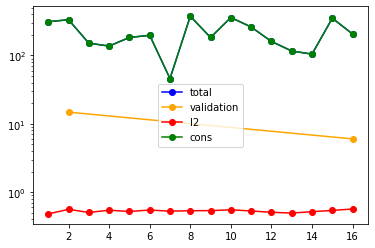

Epoch time: 169.262580782s

Epoch: 2 (lr = 1e-07)
Beginning training iphi = 0
   Loading data
      Loading time: 12.378s
   Creating training set
   Starting training
   [2,   500] loss: 178.772036
      L2 loss: 0.515481
      conservation loss: 178.772036
   [2,  1000] loss: 139.278157
      L2 loss: 0.503857
      conservation loss: 139.278157
   [2,  1500] loss: 124.467480
      L2 loss: 0.611059
      conservation loss: 124.467480
   [2,  2000] loss: 190.732173
      L2 loss: 0.575055
      conservation loss: 190.732173
      Running validation set
         Validation loss: 37.788
   [2,  2500] loss: 173.425773
      L2 loss: 0.519265
      conservation loss: 173.425773
   [2,  3000] loss: 73.250795
      L2 loss: 0.540075
      conservation loss: 73.250795
   [2,  3500] loss: 208.251645
      L2 loss: 0.510554
      conservation loss: 208.251645
   [2,  4000] loss: 145.432248
      L2 loss: 0.510467
      conservation loss: 145.432248
      Running validation set
         Valida

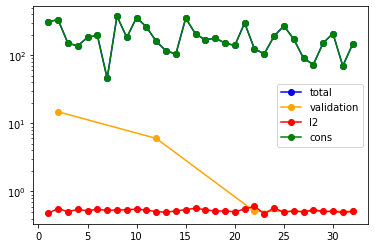

Epoch time: 167.7557355570002s

Epoch: 3 (lr = 1e-08)
Beginning training iphi = 0
   Loading data
      Loading time: 13.079s
   Creating training set
   Starting training
   [3,   500] loss: 88.054777
      L2 loss: 0.536939
      conservation loss: 88.054777
   [3,  1000] loss: 30.747496
      L2 loss: 0.532560
      conservation loss: 30.747496
   [3,  1500] loss: 29.328989
      L2 loss: 0.522485
      conservation loss: 29.328989
   [3,  2000] loss: 35.845327
      L2 loss: 0.512307
      conservation loss: 35.845327
      Running validation set
         Validation loss: 0.822
   [3,  2500] loss: 21.843931
      L2 loss: 0.501555
      conservation loss: 21.843931
   [3,  3000] loss: 23.184527
      L2 loss: 0.511686
      conservation loss: 23.184527
   [3,  3500] loss: 40.623841
      L2 loss: 0.510342
      conservation loss: 40.623841
   [3,  4000] loss: 37.992102
      L2 loss: 0.530271
      conservation loss: 37.992102
      Running validation set
         Validation loss: 

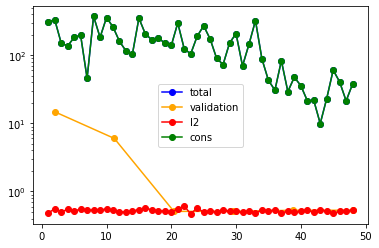

Epoch time: 171.39405515499993s

Epoch: 4 (lr = 1e-08)
Beginning training iphi = 0
   Loading data
      Loading time: 13.079s
   Creating training set
   Starting training
   [4,   500] loss: 12.749821
      L2 loss: 0.542530
      conservation loss: 12.749821
   [4,  1000] loss: 30.348908
      L2 loss: 0.519521
      conservation loss: 30.348908
   [4,  1500] loss: 18.355821
      L2 loss: 0.509908
      conservation loss: 18.355821
   [4,  2000] loss: 19.225233
      L2 loss: 0.512950
      conservation loss: 19.225233
      Running validation set
         Validation loss: 3.345
   [4,  2500] loss: 15.439230
      L2 loss: 0.526918
      conservation loss: 15.439230
   [4,  3000] loss: 41.147213
      L2 loss: 0.476475
      conservation loss: 41.147213
   [4,  3500] loss: 24.309136
      L2 loss: 0.516866
      conservation loss: 24.309136
   [4,  4000] loss: 26.291674
      L2 loss: 0.508234
      conservation loss: 26.291674
      Running validation set
         Validation loss:

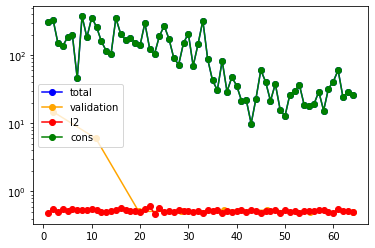

Epoch time: 171.37504063999995s

Epoch: 5 (lr = 1e-09)
Beginning training iphi = 0
   Loading data
      Loading time: 13.004s
   Creating training set
   Starting training
   [5,   500] loss: 9.437390
      L2 loss: 0.528262
      conservation loss: 9.437390
   [5,  1000] loss: 7.252842
      L2 loss: 0.518396
      conservation loss: 7.252842
   [5,  1500] loss: 12.482608
      L2 loss: 0.519703
      conservation loss: 12.482608
   [5,  2000] loss: 5.764842
      L2 loss: 0.520462
      conservation loss: 5.764842
      Running validation set
         Validation loss: 0.413
   [5,  2500] loss: 6.050995
      L2 loss: 0.547702
      conservation loss: 6.050995
   [5,  3000] loss: 18.672525
      L2 loss: 0.488918
      conservation loss: 18.672525
   [5,  3500] loss: 7.124528
      L2 loss: 0.458762
      conservation loss: 7.124528
   [5,  4000] loss: 6.312376
      L2 loss: 0.517150
      conservation loss: 6.312376
      Running validation set
         Validation loss: 0.391
Finis

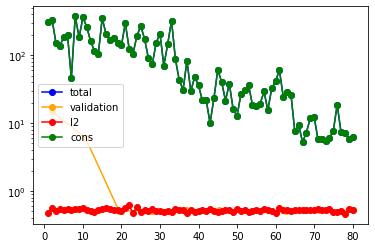

Epoch time: 172.36884372699933s

Epoch: 6 (lr = 1e-09)
Beginning training iphi = 0
   Loading data
      Loading time: 26.368s
   Creating training set
   Starting training
   [6,   500] loss: 16.484596
      L2 loss: 0.536938
      conservation loss: 16.484596
   [6,  1000] loss: 4.866044
      L2 loss: 0.532767
      conservation loss: 4.866044
   [6,  1500] loss: 5.306158
      L2 loss: 0.465569
      conservation loss: 5.306158
   [6,  2000] loss: 12.768801
      L2 loss: 0.560707
      conservation loss: 12.768801
      Running validation set
         Validation loss: 0.411
   [6,  2500] loss: 6.067454
      L2 loss: 0.481046
      conservation loss: 6.067454
   [6,  3000] loss: 8.285922
      L2 loss: 0.507028
      conservation loss: 8.285922
   [6,  3500] loss: 6.546783
      L2 loss: 0.499859
      conservation loss: 6.546783
   [6,  4000] loss: 7.109818
      L2 loss: 0.496671
      conservation loss: 7.109818
      Running validation set
         Validation loss: 0.522
Finis

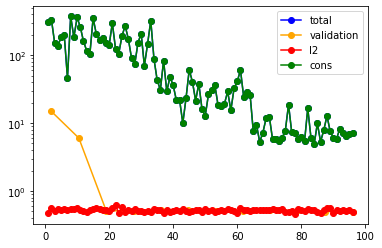

Epoch time: 185.35180956099975s

Epoch: 7 (lr = 1.0000000000000002e-10)
Beginning training iphi = 0
   Loading data
      Loading time: 26.603s
   Creating training set
   Starting training
   [7,   500] loss: 4.688446
      L2 loss: 0.542656
      conservation loss: 4.688446
   [7,  1000] loss: 5.438807
      L2 loss: 0.511113
      conservation loss: 5.438807
   [7,  1500] loss: 4.650918
      L2 loss: 0.537900
      conservation loss: 4.650918
   [7,  2000] loss: 6.384336
      L2 loss: 0.490235
      conservation loss: 6.384336
      Running validation set
         Validation loss: 0.320
   [7,  2500] loss: 15.446346
      L2 loss: 0.512323
      conservation loss: 15.446346
   [7,  3000] loss: 5.316881
      L2 loss: 0.496054
      conservation loss: 5.316881
   [7,  3500] loss: 5.206316
      L2 loss: 0.467232
      conservation loss: 5.206316
   [7,  4000] loss: 4.616143
      L2 loss: 0.491150
      conservation loss: 4.616143
      Running validation set
         Validation lo

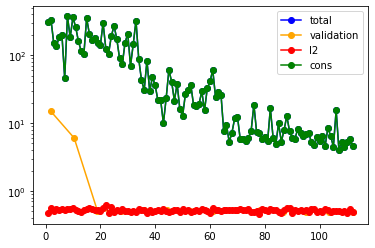

Epoch time: 187.57877148199987s

Epoch: 8 (lr = 1.0000000000000002e-10)
Beginning training iphi = 0
   Loading data
      Loading time: 13.640s
   Creating training set
   Starting training
   [8,   500] loss: 4.692768
      L2 loss: 0.495757
      conservation loss: 4.692768
   [8,  1000] loss: 4.200950
      L2 loss: 0.586907
      conservation loss: 4.200950
   [8,  1500] loss: 4.621506
      L2 loss: 0.515614
      conservation loss: 4.621506
   [8,  2000] loss: 6.232292
      L2 loss: 0.445244
      conservation loss: 6.232292
      Running validation set
         Validation loss: 0.353
   [8,  2500] loss: 5.304156
      L2 loss: 0.557987
      conservation loss: 5.304156
   [8,  3000] loss: 4.747273
      L2 loss: 0.520641
      conservation loss: 4.747273
   [8,  3500] loss: 7.102835
      L2 loss: 0.552159
      conservation loss: 7.102835
   [8,  4000] loss: 4.985974
      L2 loss: 0.545364
      conservation loss: 4.985974
      Running validation set
         Validation loss

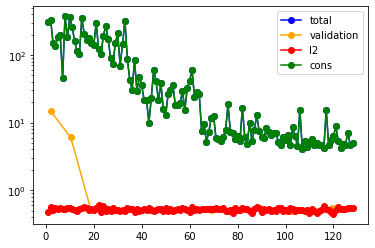

Epoch time: 175.9930101889995s

Epoch: 9 (lr = 1.0000000000000001e-11)
Beginning training iphi = 0
   Loading data
      Loading time: 13.317s
   Creating training set
   Starting training
   [9,   500] loss: 4.952860
      L2 loss: 0.510233
      conservation loss: 4.952860
   [9,  1000] loss: 3.910159
      L2 loss: 0.552963
      conservation loss: 3.910159
   [9,  1500] loss: 3.981690
      L2 loss: 0.547783
      conservation loss: 3.981690
   [9,  2000] loss: 4.401717
      L2 loss: 0.519437
      conservation loss: 4.401717
      Running validation set
         Validation loss: 0.312
   [9,  2500] loss: 4.885475
      L2 loss: 0.500629
      conservation loss: 4.885475
   [9,  3000] loss: 5.927441
      L2 loss: 0.525811
      conservation loss: 5.927441
   [9,  3500] loss: 6.957231
      L2 loss: 0.516196
      conservation loss: 6.957231
   [9,  4000] loss: 4.418711
      L2 loss: 0.534684
      conservation loss: 4.418711
      Running validation set
         Validation loss:

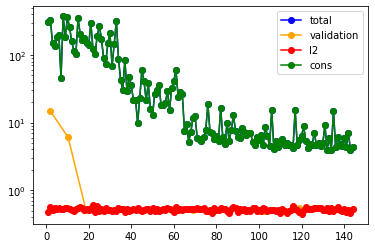

Epoch time: 174.280698949s

Epoch: 10 (lr = 1.0000000000000001e-11)
Beginning training iphi = 0
   Loading data
      Loading time: 13.338s
   Creating training set
   Starting training
   [10,   500] loss: 8.072563
      L2 loss: 0.481597
      conservation loss: 8.072563
   [10,  1000] loss: 5.362490
      L2 loss: 0.499132
      conservation loss: 5.362490
   [10,  1500] loss: 4.207320
      L2 loss: 0.532395
      conservation loss: 4.207320
   [10,  2000] loss: 5.130080
      L2 loss: 0.503683
      conservation loss: 5.130080
      Running validation set
         Validation loss: 0.294
   [10,  2500] loss: 6.110874
      L2 loss: 0.496613
      conservation loss: 6.110874
   [10,  3000] loss: 4.306139
      L2 loss: 0.513248
      conservation loss: 4.306139
   [10,  3500] loss: 5.627723
      L2 loss: 0.532865
      conservation loss: 5.627723
   [10,  4000] loss: 8.630463
      L2 loss: 0.516318
      conservation loss: 8.630463
      Running validation set
         Validation 

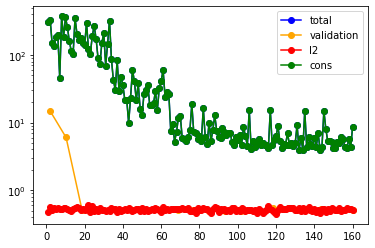

Epoch time: 173.85279720499966s

Epoch: 11 (lr = 1.0000000000000002e-12)
Beginning training iphi = 0
   Loading data
      Loading time: 13.169s
   Creating training set
   Starting training
   [11,   500] loss: 4.167761
      L2 loss: 0.525977
      conservation loss: 4.167761
   [11,  1000] loss: 4.687988
      L2 loss: 0.535662
      conservation loss: 4.687988
   [11,  1500] loss: 3.816621
      L2 loss: 0.577303
      conservation loss: 3.816621
   [11,  2000] loss: 4.581349
      L2 loss: 0.453842
      conservation loss: 4.581349
      Running validation set
         Validation loss: 0.266
   [11,  2500] loss: 6.167002
      L2 loss: 0.543114
      conservation loss: 6.167002
   [11,  3000] loss: 4.099781
      L2 loss: 0.543171
      conservation loss: 4.099781
   [11,  3500] loss: 4.443774
      L2 loss: 0.502039
      conservation loss: 4.443774
   [11,  4000] loss: 7.094523
      L2 loss: 0.503796
      conservation loss: 7.094523
      Running validation set
         Valida

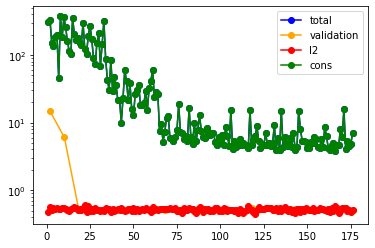

Epoch time: 175.10607417699975s

Epoch: 12 (lr = 1.0000000000000002e-12)
Beginning training iphi = 0
   Loading data
      Loading time: 13.434s
   Creating training set
   Starting training
   [12,   500] loss: 4.102999
      L2 loss: 0.514846
      conservation loss: 4.102999
   [12,  1000] loss: 4.704331
      L2 loss: 0.455288
      conservation loss: 4.704331


KeyboardInterrupt: ignored

In [21]:
start = timeit.default_timer()
criterion = nn.MSELoss()

# optimizer = optim.Adam(net.parameters())
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=lr_decay)

train_loss = []
val_loss = []

for epoch in range(num_epochs):

  lr_epoch = [group['lr'] for group in optimizer.param_groups][0]

  print('Epoch: {} (lr = {})'.format(epoch+1,lr_epoch)) 
  
  epoch1 = timeit.default_timer() 
  end = 0
  for iphi in range(nphi):

    print('Beginning training iphi = {}'.format(iphi))
    print('   Loading data')
    load1 = timeit.default_timer()
    f,df,num_nodes,zvars,cons = load_data_hdf(iphi)
    load2 = timeit.default_timer()
    print('      Loading time: %.3fs' % (load2-load1))

    print('   Creating training set')
    trainloader,valloader,f_test,df_test,temp_test,vol_test = split_data(f,df,cons,num_nodes)
    del f,df
    
    train1 = timeit.default_timer()
    ### gather testing data
    if epoch == 0:
      if iphi == 0:
        f_all_test,df_all_test,temp_all_test,vol_all_test = f_test,df_test,temp_test,vol_test
        del f_test,df_test,temp_test,vol_test

        print('   Starting training')
        train_loss, l2_loss, cons_loss, val_loss, cons_array, end = \
                                   train(trainloader,valloader,0,epoch,end,zvars,cons)

      else:
        f_all_test = np.vstack((f_all_test,f_test))
        df_all_test = np.vstack((df_all_test,df_test))
        temp_all_test = np.vstack((temp_all_test,temp_test))
        vol_all_test = np.vstack((vol_all_test,vol_test))
        del f_test,df_test,temp_test,vol_test

        print('   Starting training')
        train_loss_to_app, l2_loss_to_app, cons_loss_to_app, val_loss_to_app, cons_to_cat, end = \
                                   train(trainloader,valloader,0,epoch,end,zvars,cons)

        for loss1 in train_loss_to_app:
          train_loss.append(loss1)
        for loss2 in val_loss_to_app:
          val_loss.append(loss2)
        cons_array = np.concatenate((cons_array, cons_to_cat), axis=1)
    
    else:
      del f_test,df_test,temp_test,vol_test
      print('   Starting training')
      train_loss_to_app, l2_loss_to_app, cons_loss_to_app, val_loss_to_app, cons_to_cat, end = \
                                 train(trainloader,valloader,0,epoch,end,zvars,cons)

      for loss1 in train_loss_to_app:
          train_loss.append(loss1)
      for loss2 in l2_loss_to_app:
          l2_loss.append(loss2)         
      for loss3 in cons_loss_to_app:
          cons_loss.append(loss3)          
      for loss4 in val_loss_to_app:
          val_loss.append(loss2)      
      cons_array = np.concatenate((cons_array, cons_to_cat), axis=0)
         
    train2 = timeit.default_timer()
    print('Finished tranining iphi = {}'.format(iphi))
    print('   Training time for iphi = %d: %.3fs' % (iphi,train2-train1))
  
  train_iterations = np.linspace(1,len(train_loss),len(train_loss))
  val_iterations = np.linspace(2,len(train_loss),len(val_loss))
  
  plt.plot(train_iterations,train_loss,'-o',color='blue')
  plt.plot(val_iterations,val_loss,'-o',color='orange')
  plt.plot(train_iterations,l2_loss,'-o',color='red')
  plt.plot(train_iterations,cons_loss,'-o',color='green')
  plt.legend(['total','validation','l2','cons'])
  plt.yscale('log')
  plt.show()
  
  epoch2 = timeit.default_timer()
  scheduler.step()
  print('Epoch time: {}s\n'.format(epoch2-epoch1))

print('Starting testing')
l2_error_i, cons_error_i = test(f_all_test,df_all_test,temp_all_test,vol_all_test)
print('Finished testing')

stop = timeit.default_timer()
print('Runtime: %.3fmins' % ((stop-start)/60))

In [0]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ## used to see differences between voli/e and f0_grid_vol 

# fid1 = h5py.File('/content/hdf5_data/hdf_vol.h5','r')
# fid2 = h5py.File('/content/hdf5_data/hdf_cons_fullvol.h5','r')

# vole1 = fid1['vole'][0]
# voli1 = fid1['vole'][0]

# f0_grid_vol = fid2['f0_grid_vol'][...]
# vole2 = f0_grid_vol[0]
# voli2 = f0_grid_vol[1]